In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy

In [52]:
def clean_text(text):
    """
    Recive a string and return the string in tokens without punctuations
    and in lowercase
    """
    # for each token in the sentence add to the list if is not a punctuation
    return [t for t in nlp(text.lower()) if not t.is_punct]


def normalize(tokens):
    """
    Recive al list of string and return in one string without stop words
    """
    # for each token if is not a stop word add the word to the list
    words = [t.orth_ for t in tokens if not t.is_stop]

    # return the tokens in one string
    return(" ".join(words))


def lematize(tokens):
    """
    Recive al list of string and return in one string without stop words 
    and Lematized
    """
    # for each token if is not a stop word add the lemma of the word in the list
    lemmas = [t.lemma_ for t in tokens if not t.is_stop]

    # return the tokens in one string
    return(" ".join(lemmas))

def to_vector(texto,model):
    """ 
    Receives a sentence string along with a word embedding model and 
    returns the vector representation of the sentence
    """
    tokens = texto.split() # splits the text by space and returns a list of words
    vec = np.zeros(300) # creates an empty vector of 300 dimensions
    for word in tokens: # iterates over the sentence
        if word in model: # checks if the word is both in the word embedding
            vec += model[word] # adds every word embedding to the vector
    return vec / np.linalg.norm(vec) # divides the vector by their normal

In [45]:
data = pd.read_excel(r'../data/Datos Codificados Estudio v2a.xlsx')
nlp = spacy.load('es_core_news_sm')

In [54]:
for i in range(len(data)):
    data['Palabra (concepto)'][i] = normalize(clean_text(data['Palabra (concepto)'][i]))

<BarContainer object of 26 artists>

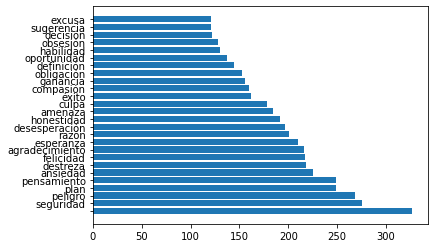

In [55]:
concept = data['Palabra (concepto)'].value_counts()
# reduce_concept = concept[concept>25]

names = list(concept.keys())
values = list(concept)

plt.barh(names, values)

In [56]:
print("Cantidad de conceptos existente", concept.shape[0])

Cantidad de conceptos existente 26


<BarContainer object of 28 artists>

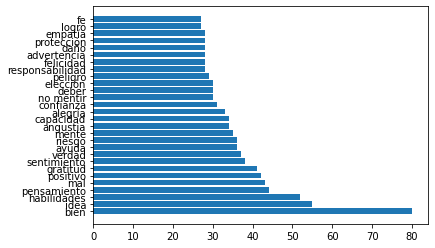

In [48]:
cod = data['Codificación'].value_counts()
reduce_cod = cod[cod>25]

names = list(reduce_cod.keys())
values = list(reduce_cod)

plt.barh(names, values)

In [49]:
print("Cantidad de codificaciones existente", cod.shape[0])

Cantidad de codificaciones existente 1296


In [50]:
print("Porcentaje de datos que solo tienen una codificación:",np.sum(cod == 1)/cod.shape[0])

Porcentaje de datos que solo tienen una codificación: 0.5169753086419753


¿Afecta esto en los resultados que se pueden obtener?
¿Podria intentar identificarlos?


In [53]:
descriptions = data['Descripción'].copy()

number_words = np.zeros(len(descriptions))

i=0
for d in descriptions:
    number_words[i]= len(nlp(d))
    i+=1

In [ ]:
uniques_words = []

for d in descriptions:
    doc = nlp(d)
    for w in doc:
        if w.orth_ not in uniques_words:
            uniques_words.append(w.orth_)

In [ ]:
print("min:", number_words.min())
print("max:", number_words.max())
print("mean:", number_words.mean())
print("std:", number_words.std())
print("\n\nTotal de palabras", number_words.sum())
print("De las cuales se tienen", len(uniques_words), "palabras únicas")

min: 1.0
max: 21.0
mean: 4.12636695018226
std: 3.1340106067803215


Total de palabras 20376.0
De las cuales se tienen 4126 palabras únicas


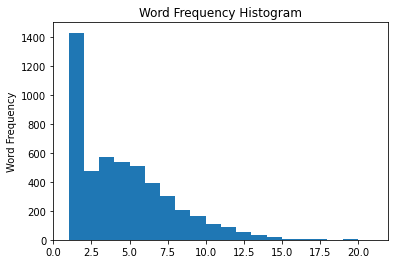

In [ ]:
plt.hist(number_words, bins=20)
plt.gca().set(title='Word Frequency Histogram', ylabel='Word Frequency');

# Matriz Visualization

In [17]:
import gensim

model = gensim.models.KeyedVectors.load_word2vec_format( 
    r'../Data/SBW-vectors-300-min5.bin.gz', # using the spanish billion words embeddings
    binary=True # the model is in binary format
)

In [18]:
pd.options.mode.chained_assignment = None # Para evitar que se muestre warnings

# Normalizacion de los conceptos, descripciones y codificaciones
for i in range(len(data)):
    data['Descripción'][i] = normalize(clean_text(data['Descripción'][i]))

In [19]:
# Creation of the matrix to make the clustering process
descriptions_matrix = np.zeros( # creatign an empty matrix
    (
        len(data), # the number of data points
        len(model['hola']) # the number of components of the word embedding
    )
)

# matrix filling 
for i,description in enumerate(data['Descripción']):
    vector = to_vector(description,model)
    descriptions_matrix[i,] = vector

# Concatenate the matrix with the data of each observation
data_matrix = np.concatenate([descriptions_matrix,data], axis=1)

#--------------------------------------------------------------------------------------
# This is the important matrix
# Remove of the 'Nan' data
data_matrix_without_nan = data_matrix[~pd.isnull(data_matrix[:,:300]).any(axis=1)]
#--------------------------------------------------------------------------------------

# reduce the matrix to the importan
data_matrix_without_nan = np.concatenate(
    (data_matrix_without_nan[:,:300],                       # Vector of the description
    np.reshape(data_matrix_without_nan[:,302], (-1, 1)),    # Cue/Concept
    np.reshape(data_matrix_without_nan[:,306], (-1, 1)),    # Codification
    np.reshape(data_matrix_without_nan[:,303], (-1, 1))     # Description of the cue
    ),
    axis = 1
)

C:\Users\dra98\AppData\Local\Temp\ipykernel_27796\1916605552.py:42: RuntimeWarning: invalid value encountered in true_divide


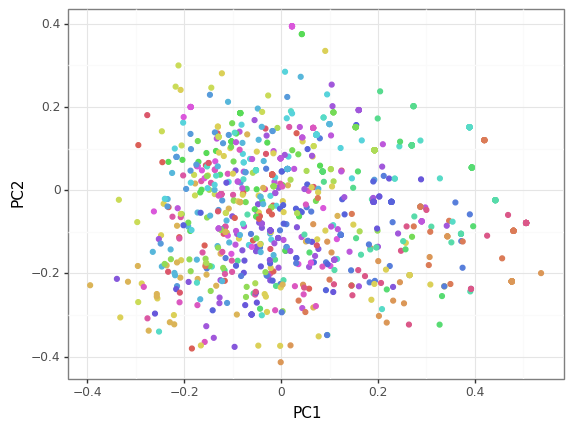

<ggplot: (174278357297)>

In [43]:
# TODO: PCA analysis 2 components y label="codificación"

from plotnine import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Primero escalamos los datos

# Aplicacion del PCA
pca = PCA(n_components=2)
temp = pca.fit_transform(data_matrix_without_nan[:,:300])
# temp = pca.fit_transform(jugadores.iloc[:,4:])
temp = pd.DataFrame(temp,columns=["PC1","PC2"])
temp["cod"] = data_matrix_without_nan[:,301]

temp=temp[temp["cod"].isin(reduce_cod.keys())]

ggplot(temp)+aes(x="PC1",y="PC2",color="cod")+geom_point(show_legend=False)+theme_bw()